FORECASTING OF INTERNATIONAL AIRLINES PASSENGER DATA USING ARIMA AND SARIMAX

In [2]:
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [5]:
df = pd.read_csv('international-airline-passengers.csv',header=None,skiprows=1)

df.columns = ['year','passengers']
df.head()

,year,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [7]:
df.tail()

,year,passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [8]:
df.drop(144,axis = 0,inplace = True)
df.tail()

,year,passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [9]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [10]:
# Converting to date time format

df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

# Setting index as year


y = df.set_index('year')

# Checking null values

y.isnull().sum()

passengers    0
dtype: int64

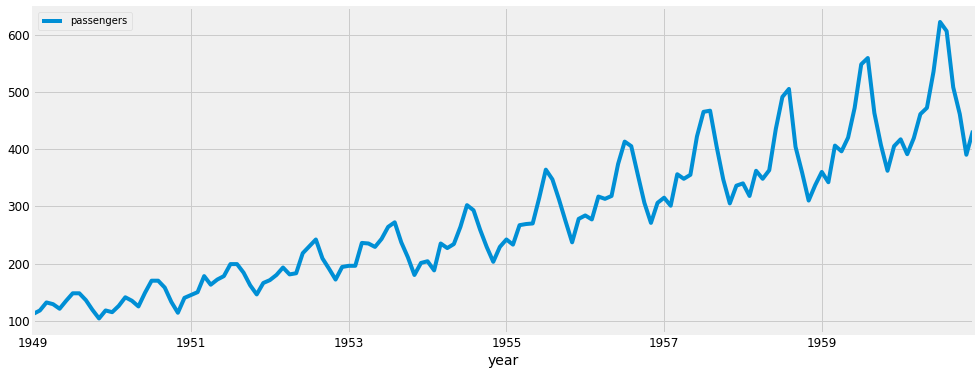

In [11]:
# Plotting for visualization

y.plot(figsize=(15, 6))

The graph shows the data as an upward trend and seasonal

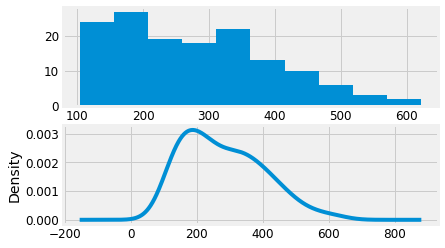

In [12]:
# Plotting and reviewing the density distribution

plt.figure(1)
plt.subplot(211)
y.passengers.hist()
plt.subplot(212)
y.passengers.plot(kind = 'kde')


#From the above we can see it doesn't follow a gussian distribution.
So Transformatios might be useful prior to modelling.

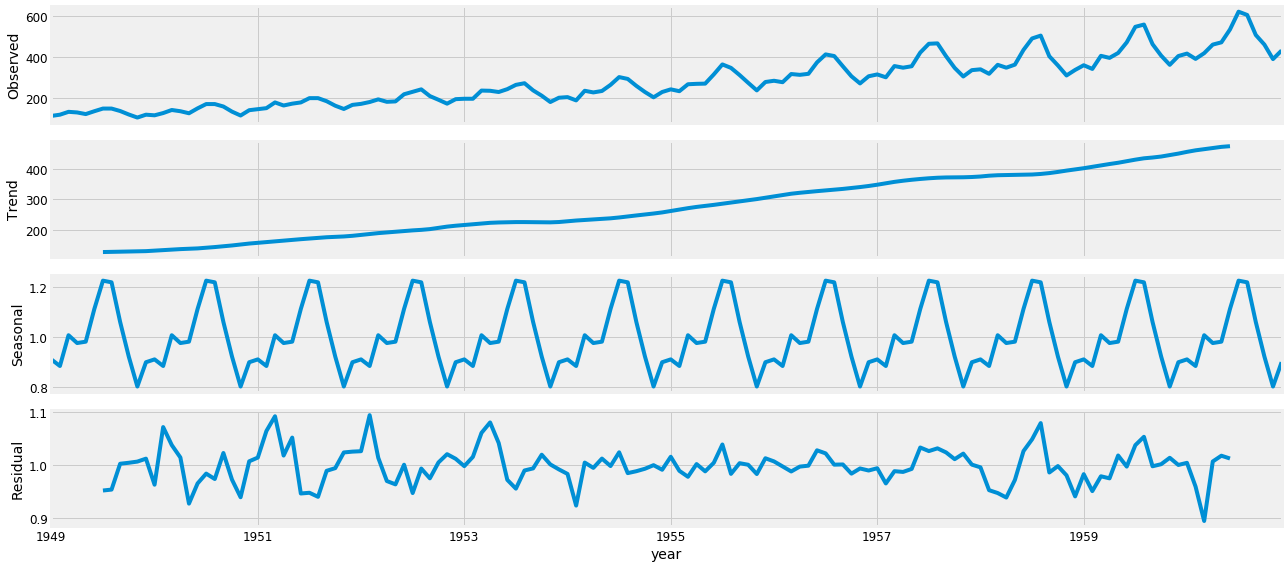

In [13]:
# Decomposing using statsmodel

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()

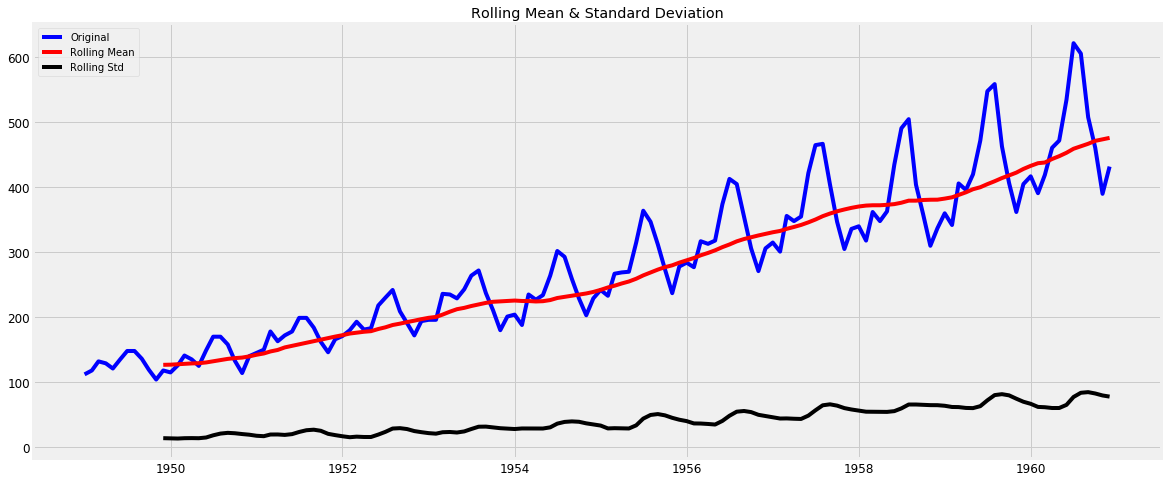

In [16]:
# Testing Stationary

#Determing rolling statistics
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [17]:
# Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
# We can make a function so that it will be easy to perform the test till the data becomes stationary

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

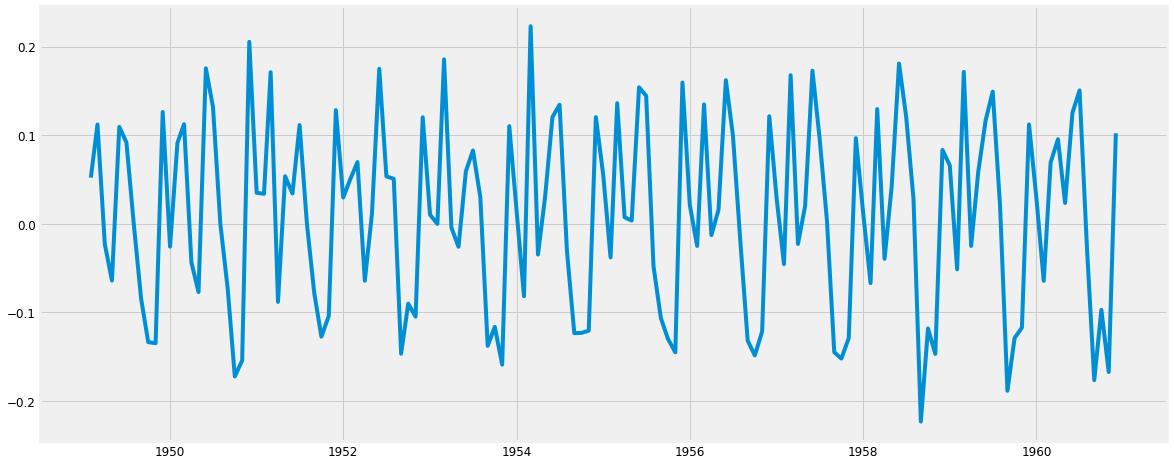

In [19]:
# Making the data Stationary

ts_log = np.log(y)

ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

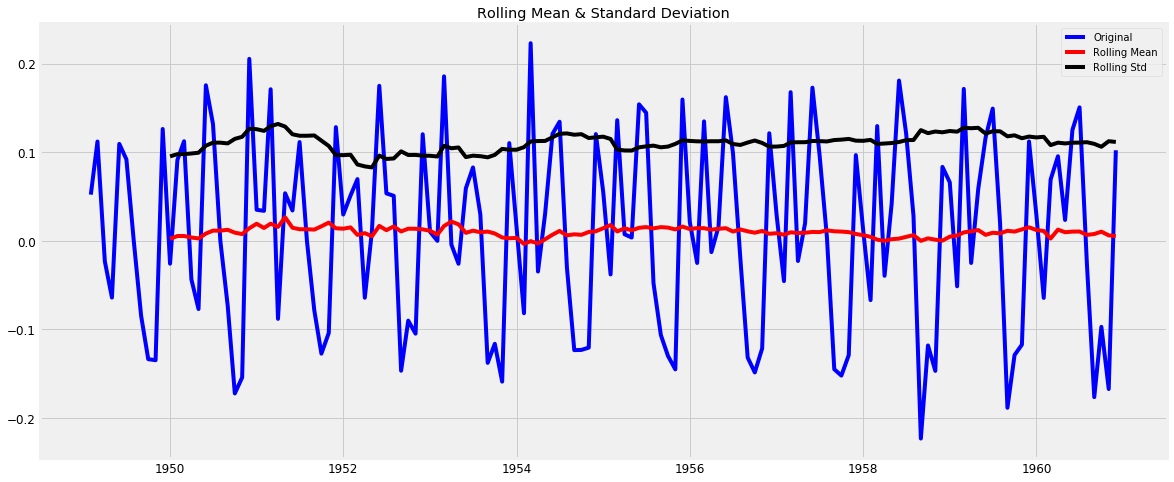

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
# Testing Stationary

ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

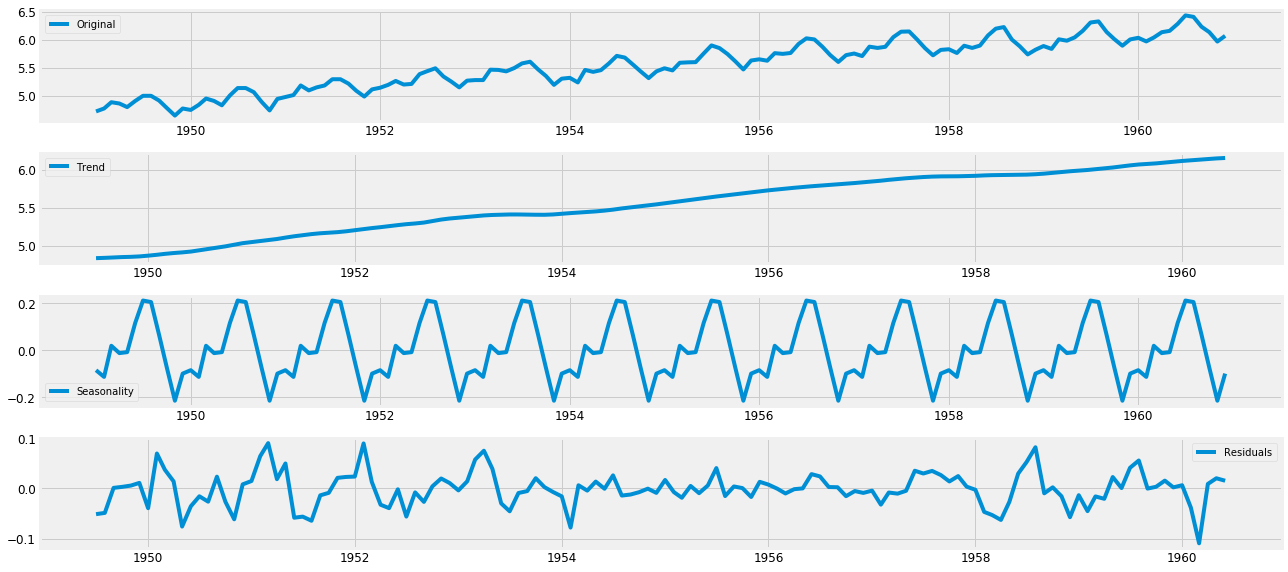

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

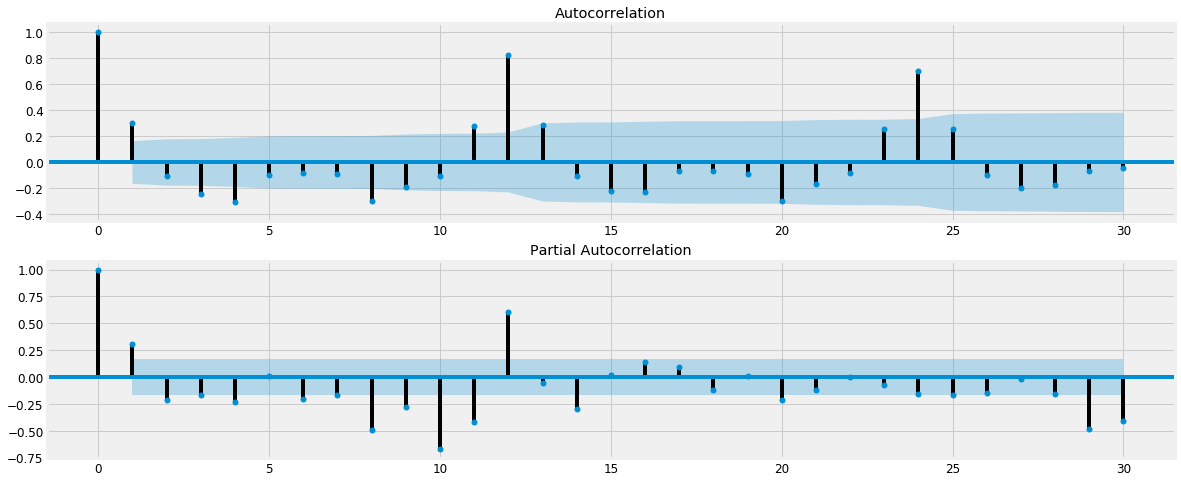

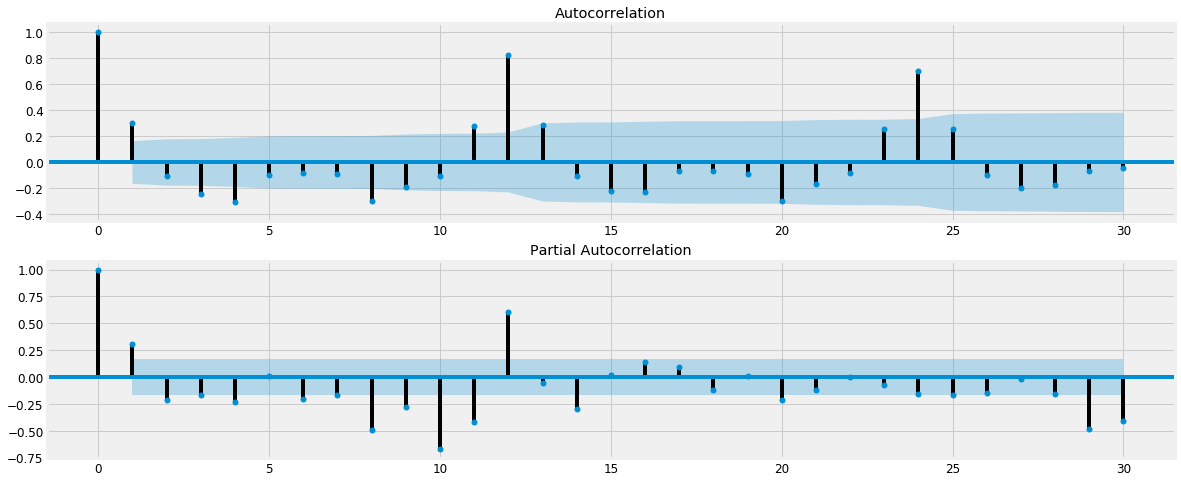

In [25]:
# Finding p,d and q values and applying ARIMA

#Differenciating

ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

# P and q vaues can be found by plotting acf and pacf plots

plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca(),lags=30)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(),lags=30)

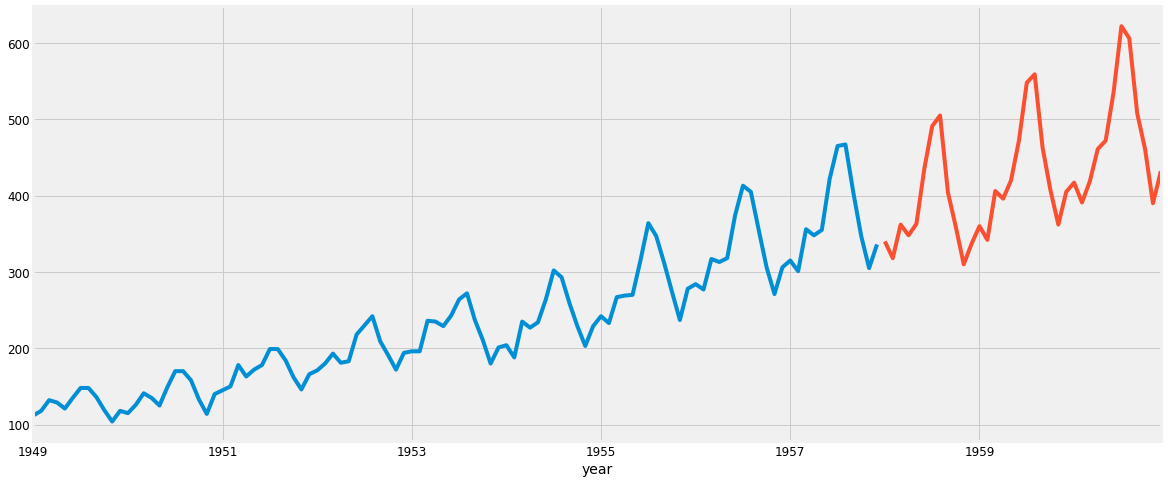

In [26]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [27]:

# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Sun, 21 Jul 2019   AIC                            994.461
Time:                        18:24:28   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [31]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.6263806945527, MSE:187165.58527286808


In [32]:
# Predicted values


predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    8.743423
1958-02-01    7.109318
1958-03-01    5.898541
1958-04-01    5.001426
1958-05-01    4.336717
Freq: MS, dtype: float64


In [34]:
# Reverse Differencing


predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743423
1958-02-01    15.852741
1958-03-01    21.751282
1958-04-01    26.752709
1958-05-01    31.089425
Freq: MS, dtype: float64


In [35]:
# Adding 1st month value which was previously removed while differencing:

predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743423
1958-02-01    355.852741
1958-03-01    361.751282
1958-04-01    366.752709
1958-05-01    371.089425
dtype: float64

In [38]:
# Evaluation

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,-29.591082,425.388089,409.556266,187165.585273,21.976173,432.626381


In [46]:
# Applying SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)

start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [47]:

# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 61.85565276303965, MSE:3826.1217787417345


Text(0.5, 1.0, 'RMSE: 61.8557')

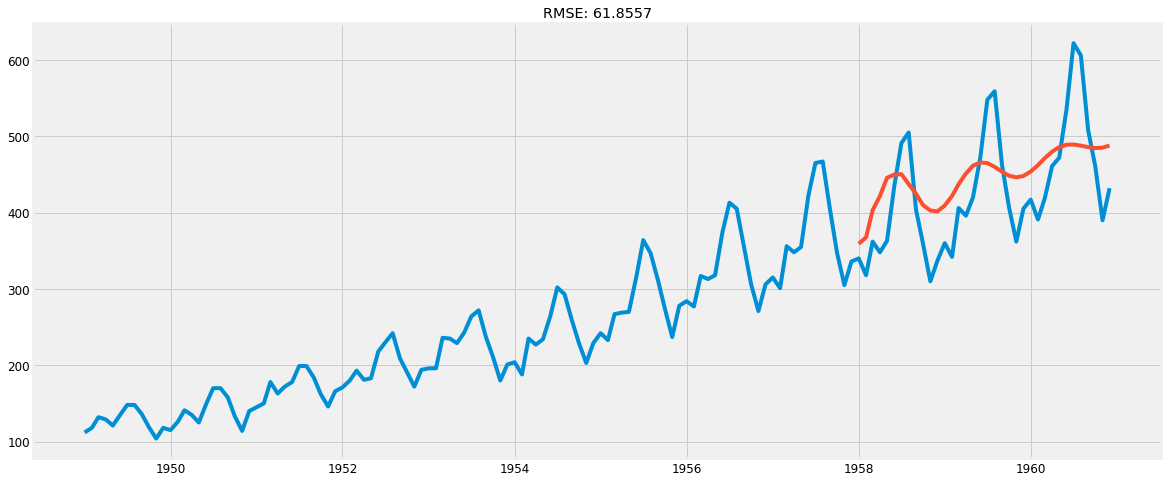

In [48]:

plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [49]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,0.374644,53.574789,49.471955,3826.121779,0.019777,61.855653
